## Feature engineering pipeline example

In [1]:
import sys
sys.path.append('../../../')

## Load dummy binary classification dataset

In [2]:
import numpy
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
# Load data
data = load_breast_cancer(as_frame=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['data'], data['target'].map({0: 1, 1: 0}), test_size=0.33, random_state=42)

## Data Visualization

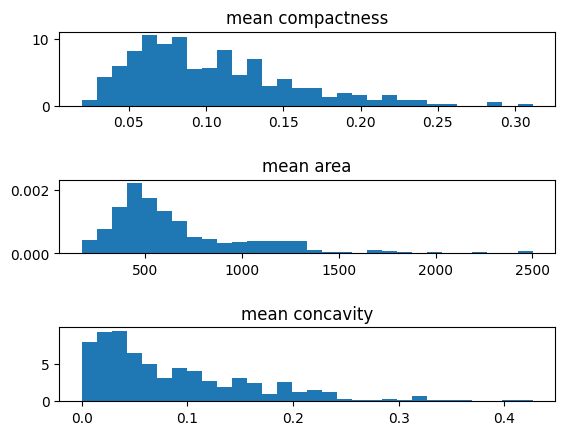

In [4]:
#Display variables distribution
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=1)
axs = gs.subplots(sharex=False, sharey=False)

axs[0].hist(X_train['mean compactness'], 30, density=True)
axs[0].set_title('mean compactness')
axs[1].hist(X_train['mean area'], 30, density=True)
axs[1].set_title('mean area')
axs[2].hist(X_train['mean concavity'], 30, density=True)
axs[2].set_title('mean concavity')

plt.show()

In [5]:
# Random NA imput to test
for col in ['mean radius', 'mean texture', 'mean perimeter']:
    X_train.loc[X_train.sample(frac=0.3).index, col] = numpy.nan

In [6]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
172,NaN,NaN,NaN,736.9,0.12570,0.15550,0.20320,0.10970,0.1966,0.07069,...,18.790,17.04,125.00,1102.0,0.15310,0.35830,0.58300,0.18270,0.3216,0.10100
407,NaN,21.37,82.63,514.5,0.07551,0.08316,0.06126,0.01867,0.1580,0.06114,...,14.400,27.01,91.63,645.8,0.09402,0.19360,0.18380,0.05601,0.2488,0.08151
56,19.210,18.57,NaN,1152.0,0.10530,0.12670,0.13230,0.08994,0.1917,0.05961,...,26.140,28.14,170.10,2145.0,0.16240,0.35110,0.38790,0.20910,0.3537,0.08294
497,NaN,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,0.1526,0.06046,...,14.060,24.34,92.82,607.3,0.12760,0.25060,0.20280,0.10530,0.3035,0.07661
301,NaN,NaN,80.43,471.3,0.08451,0.10140,0.06830,0.03099,0.1781,0.06249,...,13.460,23.07,88.13,551.3,0.10500,0.21580,0.19040,0.07625,0.2685,0.07764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
106,11.640,NaN,NaN,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097
270,NaN,16.82,NaN,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550


In [7]:
# Check number of NaN values in our dataset
X_train.isna().sum()[lambda x: x > 0]

mean radius       114
mean texture      114
mean perimeter    114
dtype: int64

### With hyperparameter tunning

In [8]:
config_yaml = {
    'optuna': {
        'create_study': {
            'study_name': 'example-study',
            'direction': 'maximize'
        },
        'run': {
            'n_trials': 10
        }
    },
    'features': {
        'outliers_': {
            1: {'features': ['mean smoothness', 'mean radius'],
                'transformers': {'CustomWinsorizer': {'capping_method': ['gaussian','iqr'],
                                                'tail': ['right','left'],
                                                'fold': (2, 4, 0.5),
                                                'add_indicators': True,
                                                'missing_values': 'ignore',
                                                'outliers_to_nan': True}
                },
                'if_optuna': True
            },
            2: {'features': ['mean area'],
                'transformers': {'LogTransformer': {'base': ['e','10']}
                },
                'if_optuna': True
            },
            3: {'features': ['mean concavity'],
                'transformers': {'PowerTransformer': {'exp': (0.5, 2, 0.5)}
                },
                'if_optuna': True
            }
        },
        'imputer_': {
            1: {'features': ['mean radius', 'mean texture'],
                'transformers': {
                    'KNNImputer': {'n_neighbors': (2, 5, 1)},
                    'ArbitraryNumberImputer': {'arbitrary_number': 999}
                },
                'if_optuna': True
            },
            2: {'features': ['mean perimeter', 'mean smoothness'],
                'transformers': {
                    'ArbitraryNumberImputer': {'arbitrary_number': 1010101}
                },
                'if_optuna': False
            }
        }
    },
    'estimator': {
        'estimator_name': 'LGBMClassifier',
        'params': {'n_estimators': (50, 400, 50),
                    'random_state': 12345},
        'if_optuna': True
    },
    'cv_technique': {
        'cv_name': 'StratifiedKFold',
        'params': {'n_splits': 5,
                'shuffle': True,
                'random_state': 12345},
        'metric': {
            'name': 'fbeta_score',
            'params': {'beta': 1,
                    'average': 'binary'}
        }
    }
}

In [9]:
from mlcycle.modeling.hyperparameter_tunning import OptunaStudy

optuna_study = OptunaStudy(config_yaml, X_train, y_train)

c:\Users\arfabreg\OneDrive - Capgemini\Documents\MG - Framework ML\ml-cycle\mlcyclevenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-09-08 16:31:28,481] A new study created in memory with name: example-study


In [10]:
optuna_study.run(n_trials=10)

[I 2023-09-08 16:31:29,798] Trial 0 finished with value: 0.8706207848518722 and parameters: {'outliers_1': 'CustomWinsorizer', 'CustomWinsorizer_capping_method_1': 'gaussian', 'CustomWinsorizer_tail_1': 'right', 'CustomWinsorizer_fold_1': 3.0, 'outliers_2': 'LogTransformer', 'LogTransformer_base_2': 'e', 'outliers_3': 'PowerTransformer', 'PowerTransformer_exp_3': 0.5, 'imputer_1': 'ArbitraryNumberImputer', 'LGBMClassifier_n_estimators': 200}. Best is trial 0 with value: 0.8706207848518722.
[I 2023-09-08 16:31:30,866] Trial 1 finished with value: 0.8706207848518722 and parameters: {'outliers_1': 'CustomWinsorizer', 'CustomWinsorizer_variables_1': 'mean smoothness', 'outliers_2': 'LogTransformer', 'LogTransformer_variables_2': 'mean area', 'outliers_3': 'PowerTransformer', 'PowerTransformer_variables_3': 'mean concavity', 'imputer_1': 'ArbitraryNumberImputer', 'ArbitraryNumberImputer_variables_1': 'mean texture'}. Best is trial 0 with value: 0.8706207848518722.
[I 2023-09-08 16:31:32,365

In [11]:
optuna_study.results()

	Best value (fbeta_score): 0.87062
	Best params:
		outliers_1: CustomWinsorizer
		CustomWinsorizer_capping_method_1: gaussian
		CustomWinsorizer_tail_1: right
		CustomWinsorizer_fold_1: 3.0
		outliers_2: LogTransformer
		LogTransformer_base_2: e
		outliers_3: PowerTransformer
		PowerTransformer_exp_3: 0.5
		imputer_1: ArbitraryNumberImputer
		LGBMClassifier_n_estimators: 200


#### Final Train-test eval

In [12]:
from mlcycle.modeling.serving import train_test_eval

train_test_eval(pipeline_config=optuna_study.pipeline_config,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test)

Value (fbeta_score): 0.9465648854961832


#### Serving

In [13]:
from mlcycle.modeling.serving import fit_model

fit_model(pipeline_config=optuna_study.pipeline_config,
          X=data['data'],
          y=data['target'].map({0: 1, 1: 0}),
          save=True)

TODO: Implement model saving logic


Pipeline(steps=[('LGBMClassifier',
                 LGBMClassifier(n_estimators=200, random_state=12345))])